In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    confusion_matrix, classification_report
)
import torch

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)


Using device: mps


In [275]:
data = pd.read_csv('../data/00/merged/sentiment_stock_merged_NVDA.csv')
print('Shape of data after loading:', data.shape)
print('Columns in the dataset:', data.columns.tolist())


Shape of data after loading: (89, 11)
Columns in the dataset: ['date_only', 'posts_per_day', 'avg_sentiment', 'avg_sentiment_normalized', 'date_only_stock', 'ticker', 'Open', 'High', 'Low', 'Close', 'Volume']


In [276]:
data['Movement'] = data.apply(lambda row: 'up' if row['Close'] > row['Open'] else 'down', axis=1)

features = [
    'date_only', 'posts_per_day', 'avg_sentiment', 'avg_sentiment_normalized',
    'date_only_stock', 'ticker', 'Open', 'High', 'Low', 'Close', 'Volume', 'Movement'
]
missing = [col for col in features if col not in data.columns]
if missing:
    print(f'Missing required columns: {missing}')
    raise SystemExit


In [277]:
date_cols = ['date_only', 'date_only_stock']
for col in date_cols:
    data[col] = pd.to_datetime(data[col])
    data[f'{col}_day']       = data[col].dt.day
    data[f'{col}_month']     = data[col].dt.month
    data[f'{col}_year']      = data[col].dt.year
    data[f'{col}_dayofweek'] = data[col].dt.dayofweek


In [278]:
numeric_features = [
    'posts_per_day', 'avg_sentiment', 'avg_sentiment_normalized',
    'Open', 'High', 'Low', 'Close', 'Volume',
    'date_only_day', 'date_only_month', 'date_only_year', 'date_only_dayofweek'
]
numeric_features = [c for c in numeric_features if c in data.columns]
print("Numeric features to be used:", numeric_features)

X = data[numeric_features]
y = data['Movement']
print(f'X shape: {X.shape}, y shape: {y.shape}')


Numeric features to be used: ['posts_per_day', 'avg_sentiment', 'avg_sentiment_normalized', 'Open', 'High', 'Low', 'Close', 'Volume', 'date_only_day', 'date_only_month', 'date_only_year', 'date_only_dayofweek']
X shape: (89, 12), y shape: (89,)


In [279]:
for col in numeric_features:
    X[col] = X[col].fillna(X[col].mean())
print('Remaining missing values per column:\n', X.isnull().sum())


Remaining missing values per column:
 posts_per_day               0
avg_sentiment               0
avg_sentiment_normalized    0
Open                        0
High                        0
Low                         0
Close                       0
Volume                      0
date_only_day               0
date_only_month             0
date_only_year              0
date_only_dayofweek         0
dtype: int64


/var/folders/yx/r372mq11725b3qtfgx955zlr0000gn/T/ipykernel_45187/2985698186.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].fillna(X[col].mean())


In [280]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [ ]:
param_grid = {
    # More estimators generally reduce variance /overfitting
    'n_estimators':      [200, 500, 1000, 1500], 

    # max_depth: Allow deeper trees to capture more complex patterns reduces underfitting
    'max_depth':         [5, 8, 10, 15, 20, None],

    # min_samples_split: Require fewer samples to split a node reduces underfitting
    'min_samples_split': [2, 5, 10, 20], 

    # min_samples_leaf: Require fewer samples in a leaf node reduces underfitting
    'min_samples_leaf':  [1, 2, 5, 10],

    # max_features: Consider more features at each split reduce underfitting, increase overfitting
    'max_features':      ['sqrt', 'log2', 0.3, 0.6, 1.0], 

    # ccp_alpha: Cost-complexity pruning - higher values increase pruning increase underfitting
    'ccp_alpha':         [0.0, 0.001, 0.005, 0.01] # Included 0 for no pruning and slightly larger values
}
print("Starting randomized search...")
rand_search = RandomizedSearchCV(
    RandomForestClassifier(
        random_state=42,
        oob_score=True,
        bootstrap=True
    ),
    param_distributions=param_grid,
    n_iter=50,
    cv=TimeSeriesSplit(n_splits=5),
    scoring='accuracy',
    return_train_score=True,
    n_jobs=-1,
    random_state=42
)

rand_search.fit(X_train, y_train)

results = pd.DataFrame(rand_search.cv_results_)
results['gap'] = results['mean_train_score'] - results['mean_test_score']
print(results[['params', 'mean_train_score', 'mean_test_score', 'gap']])

best_model = rand_search.best_estimator_
print('Best Hyperparameters:', rand_search.best_params_)


Starting randomized search...
                                               params  mean_train_score  \
0   {'n_estimators': 1000, 'min_samples_split': 5,...          0.834742   
1   {'n_estimators': 1500, 'min_samples_split': 2,...          0.671037   
2   {'n_estimators': 200, 'min_samples_split': 20,...          0.692534   
3   {'n_estimators': 1000, 'min_samples_split': 20...          0.700697   
4   {'n_estimators': 1000, 'min_samples_split': 10...          0.781060   
5   {'n_estimators': 1500, 'min_samples_split': 5,...          1.000000   
6   {'n_estimators': 200, 'min_samples_split': 20,...          0.680604   
7   {'n_estimators': 200, 'min_samples_split': 5, ...          0.992585   
8   {'n_estimators': 1000, 'min_samples_split': 5,...          0.851495   
9   {'n_estimators': 500, 'min_samples_split': 10,...          0.663844   
10  {'n_estimators': 1000, 'min_samples_split': 2,...          0.987322   
11  {'n_estimators': 1000, 'min_samples_split': 5,...          0.99258

In [282]:
y_pred = best_model.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, pos_label='up'))
print('Recall:',    recall_score(y_test, y_pred, pos_label='up'))
print('\nClassification Report:\n', classification_report(y_test, y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))


Accuracy: 0.6666666666666666
Precision: 0.5833333333333334
Recall: 0.875

Classification Report:
               precision    recall  f1-score   support

        down       0.83      0.50      0.62        10
          up       0.58      0.88      0.70         8

    accuracy                           0.67        18
   macro avg       0.71      0.69      0.66        18
weighted avg       0.72      0.67      0.66        18

Confusion Matrix:
 [[5 5]
 [1 7]]


In [294]:
importances = pd.Series(best_model.feature_importances_, index=numeric_features)
print("Feature Importances:\n", importances.sort_values(ascending=False))

cv_scores = cross_val_score(best_model, X, y, cv=3)
print(f"\nCross-validation accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


Feature Importances:
 date_only_dayofweek         0.205609
Open                        0.152721
Close                       0.133151
Volume                      0.123205
date_only_month             0.086910
date_only_day               0.075554
posts_per_day               0.055400
High                        0.045337
Low                         0.041792
avg_sentiment               0.040867
avg_sentiment_normalized    0.037739
date_only_year              0.001714
dtype: float64

Cross-validation accuracy: 0.6169 ± 0.0704


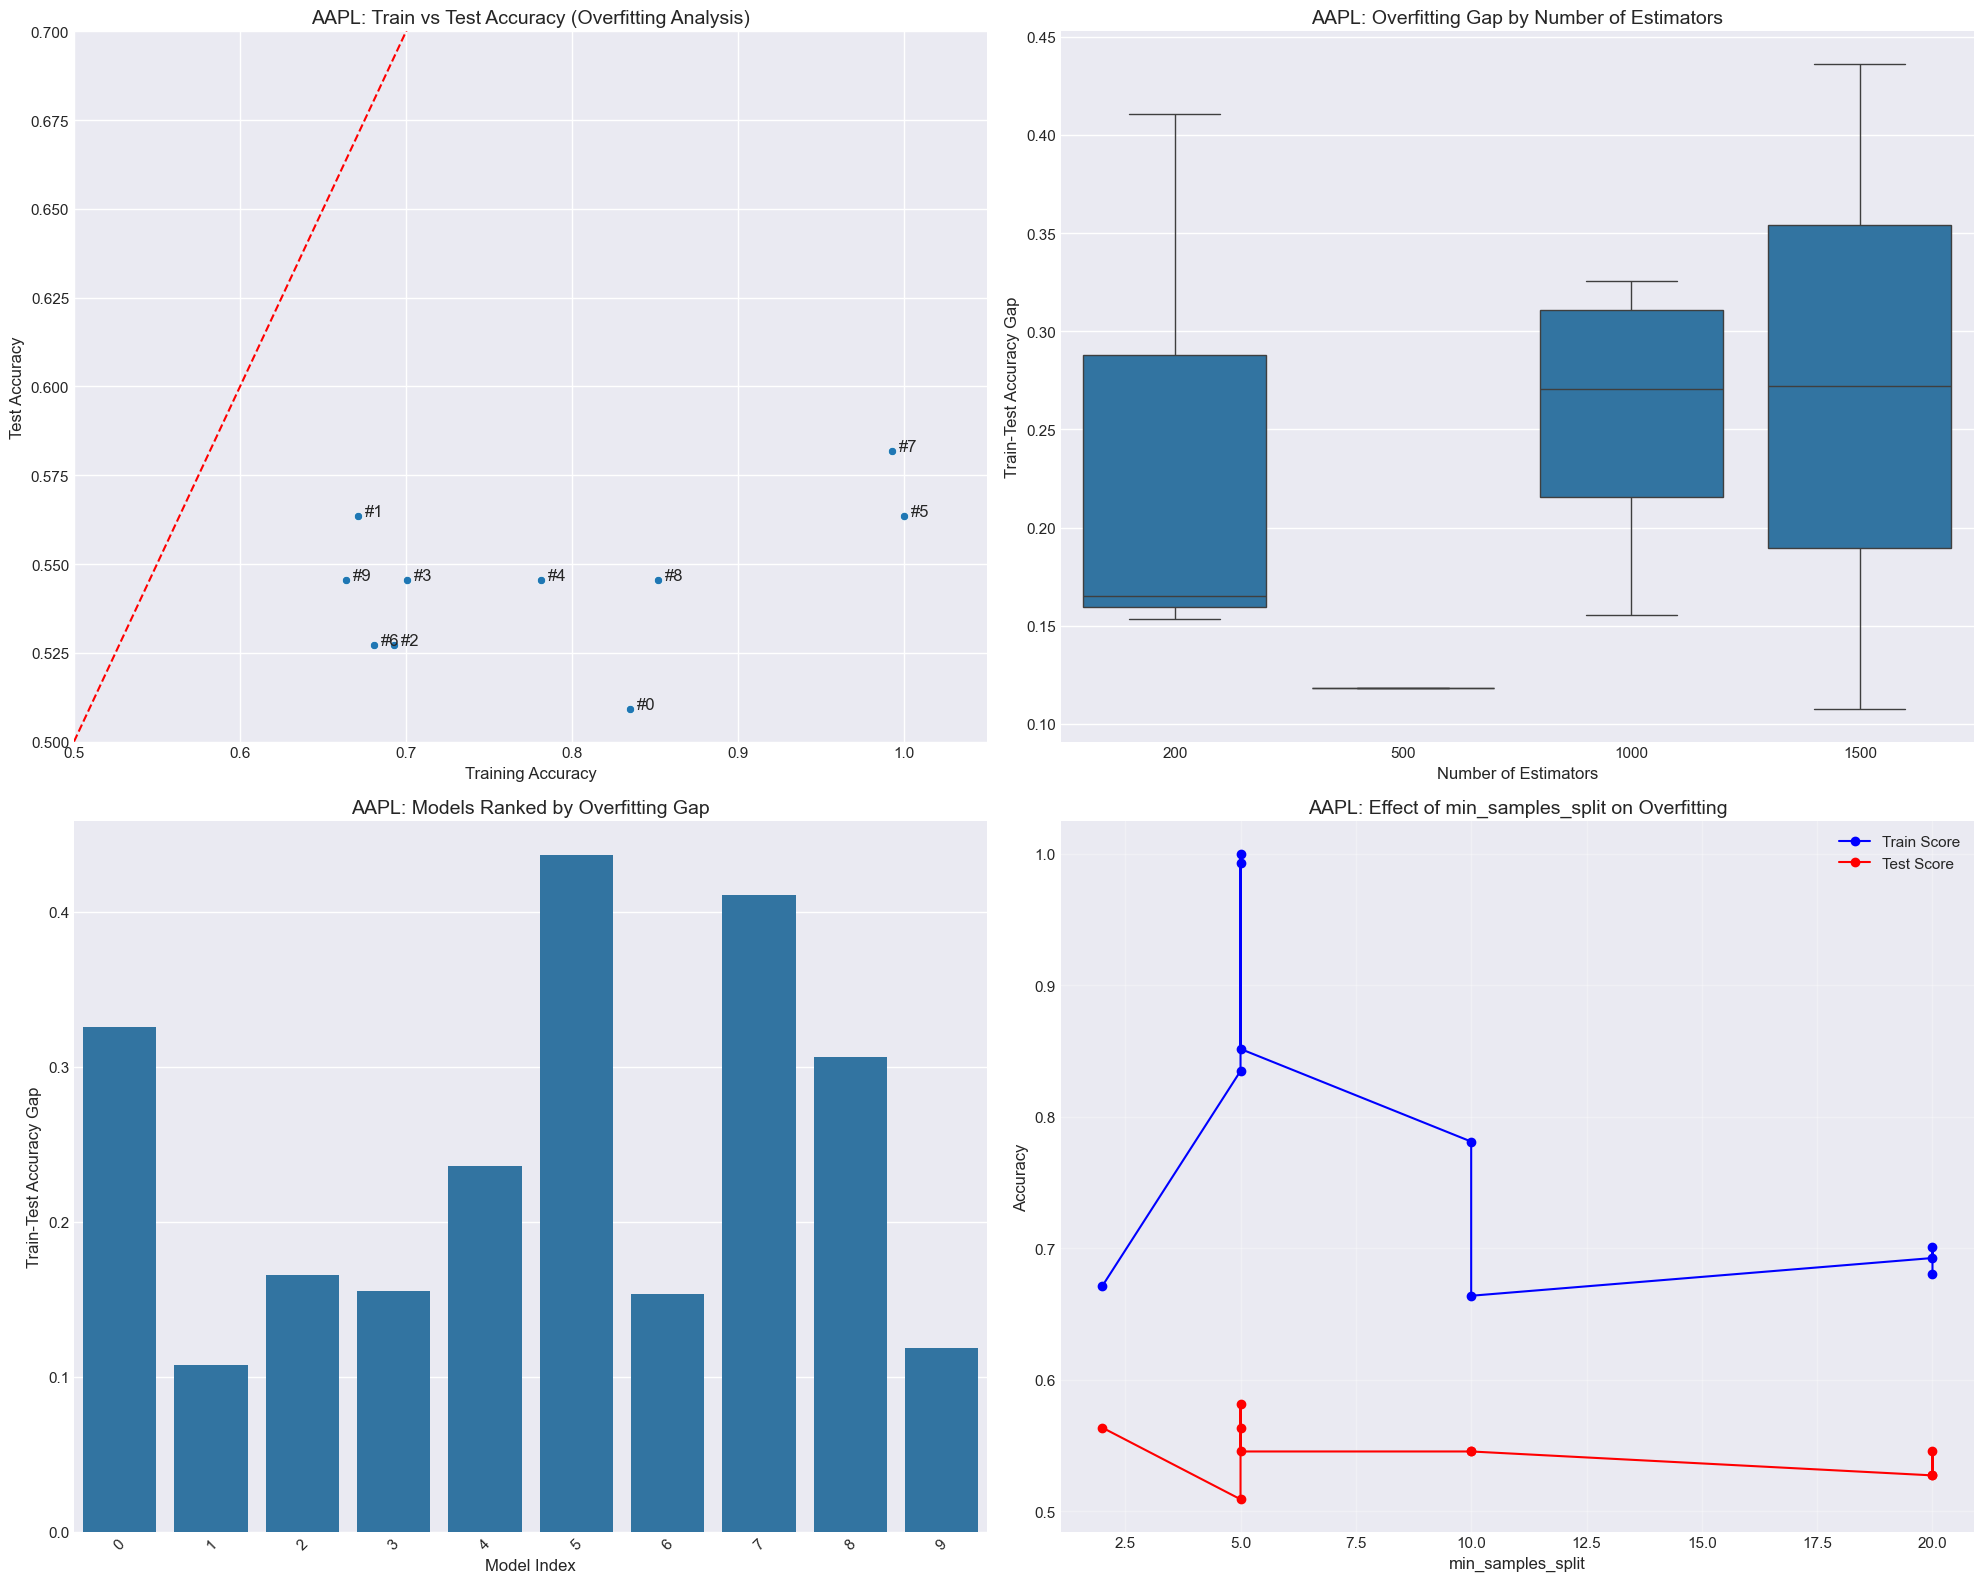

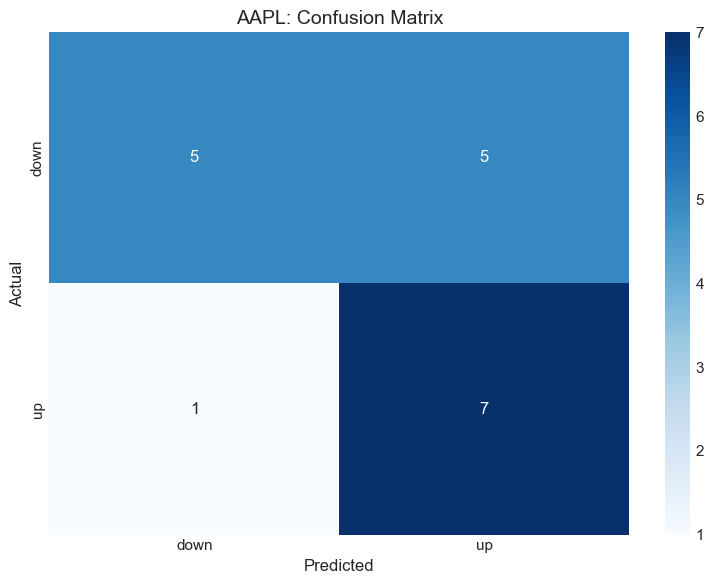

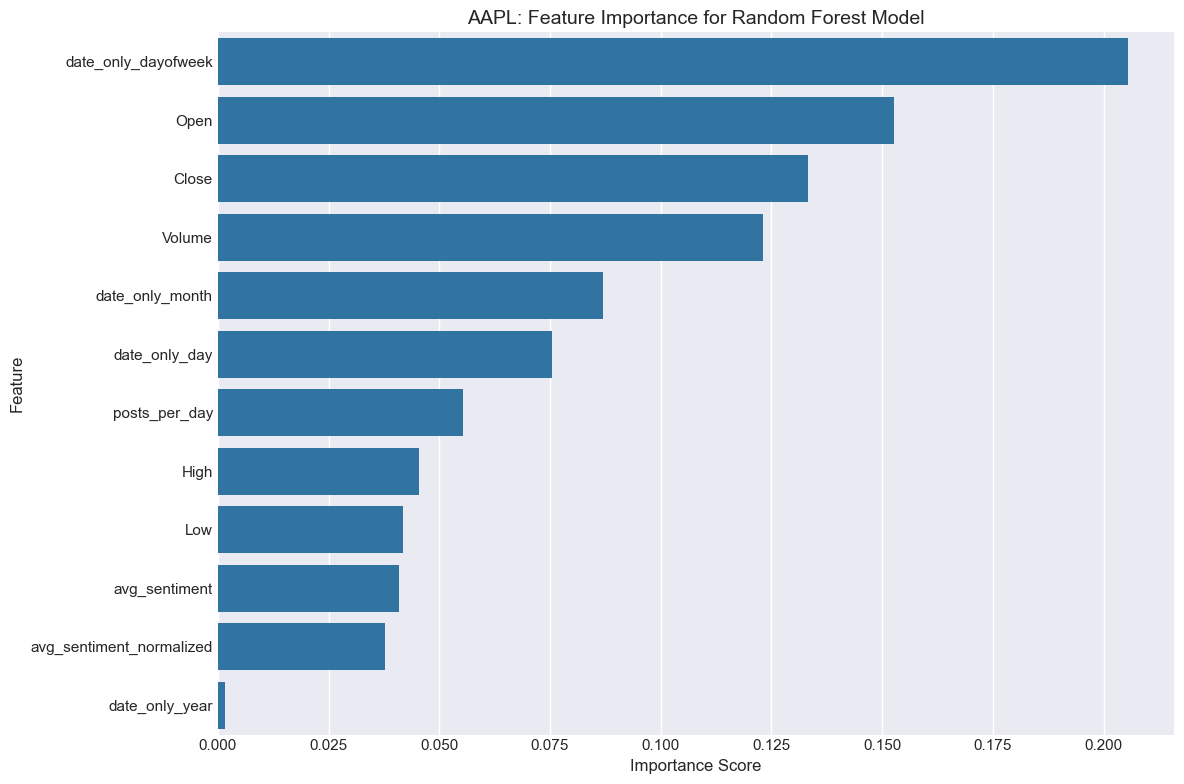

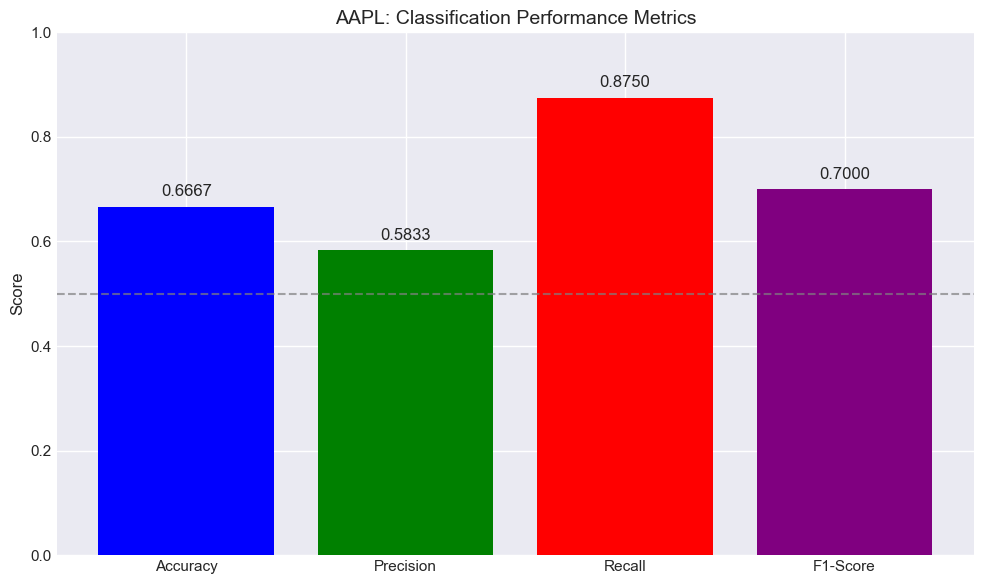

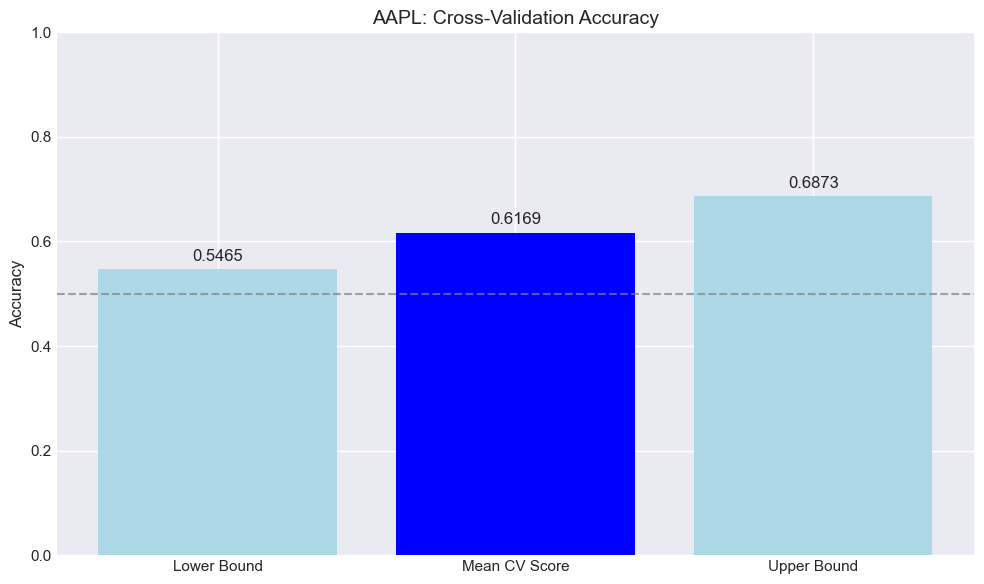

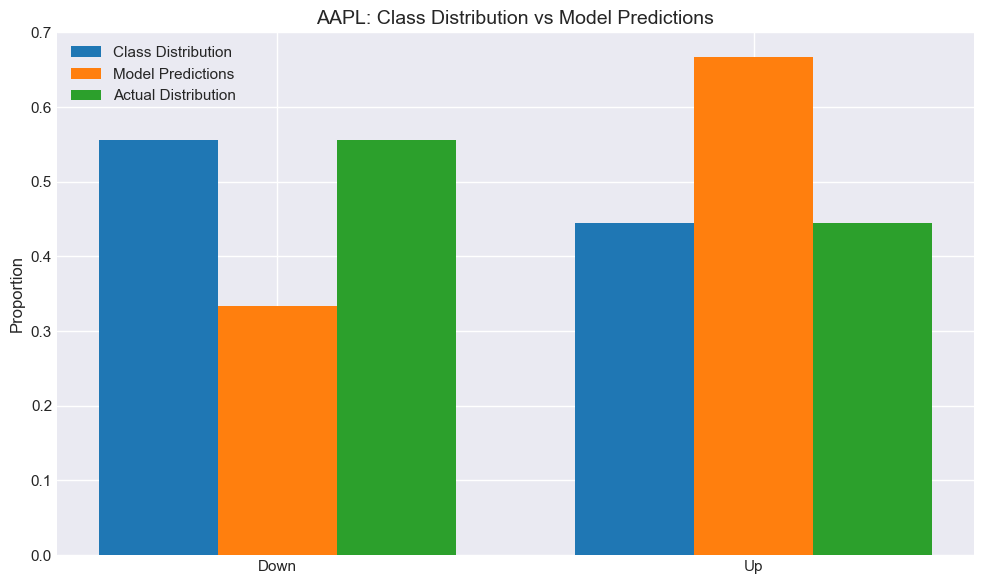

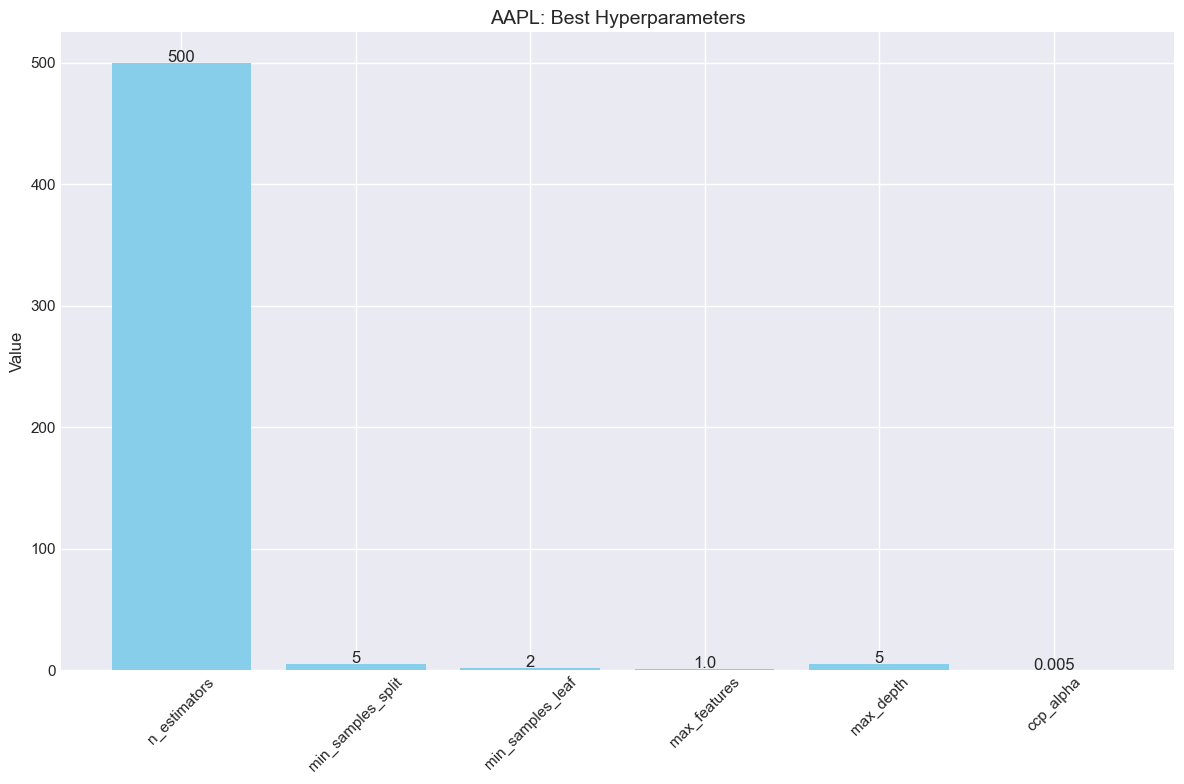

In [288]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Recreate results dataframe from the AAPL output
# Using the first 10 rows for visualization
results = pd.DataFrame({
    'n_estimators': [1000, 1500, 200, 1000, 1000, 1500, 200, 200, 1000, 500],
    'min_samples_split': [5, 2, 20, 20, 10, 5, 20, 5, 5, 10],
    'mean_train_score': [0.834742, 0.671037, 0.692534, 0.700697, 0.781060, 
                         1.000000, 0.680604, 0.992585, 0.851495, 0.663844],
    'mean_test_score': [0.509091, 0.563636, 0.527273, 0.545455, 0.545455,
                        0.563636, 0.527273, 0.581818, 0.545455, 0.545455],
    'gap': [0.325652, 0.107401, 0.165261, 0.155243, 0.235606, 
            0.436364, 0.153331, 0.410767, 0.306040, 0.118390]
})

# Set up the figure for multiple plots
plt.figure(figsize=(20, 16))

# 1. Train vs Test Accuracy Gap (Overfitting Analysis)
plt.subplot(2, 2, 1)
sns.scatterplot(data=results, x='mean_train_score', y='mean_test_score')
plt.plot([0.5, 1.0], [0.5, 1.0], 'r--')  # Diagonal line where train=test
plt.xlim(0.5, 1.05)
plt.ylim(0.5, 0.7)
plt.title('AAPL: Train vs Test Accuracy (Overfitting Analysis)', fontsize=14)
plt.xlabel('Training Accuracy')
plt.ylabel('Test Accuracy')
for i, row in results.iterrows():
    plt.annotate(f"#{i}", (row['mean_train_score'], row['mean_test_score']), 
                 xytext=(5, 0), textcoords='offset points')

# 2. Gap vs n_estimators
plt.subplot(2, 2, 2)
sns.boxplot(data=results, x='n_estimators', y='gap')
plt.title('AAPL: Overfitting Gap by Number of Estimators', fontsize=14)
plt.xlabel('Number of Estimators')
plt.ylabel('Train-Test Accuracy Gap')

# 3. Gap visualization sorted
plt.subplot(2, 2, 3)
sorted_results = results.sort_values('gap', ascending=False)
sns.barplot(data=sorted_results, x=sorted_results.index, y='gap')
plt.title('AAPL: Models Ranked by Overfitting Gap', fontsize=14)
plt.xlabel('Model Index')
plt.ylabel('Train-Test Accuracy Gap')
plt.xticks(rotation=45)

# 4. Training vs Test scores by min_samples_split
plt.subplot(2, 2, 4)
sorted_by_mss = results.sort_values('min_samples_split')
plt.plot(sorted_by_mss['min_samples_split'], sorted_by_mss['mean_train_score'], 'bo-', label='Train Score')
plt.plot(sorted_by_mss['min_samples_split'], sorted_by_mss['mean_test_score'], 'ro-', label='Test Score')
plt.title('AAPL: Effect of min_samples_split on Overfitting', fontsize=14)
plt.xlabel('min_samples_split')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../data/images/aapl_random_forest_overfitting_analysis.png')
plt.show()

# Visualizing the confusion matrix from the provided data
plt.figure(figsize=(8, 6))
cm = np.array([[5, 5], 
               [1, 7]])  # From the provided confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['down', 'up'], 
            yticklabels=['down', 'up'])
plt.title('AAPL: Confusion Matrix', fontsize=14)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig('../data/images/aapl_confusion_matrix.png')
plt.show()

# Feature importance visualization using the provided data
feature_names = [
    'date_only_dayofweek', 'Open', 'Close', 'Volume', 'date_only_month',
    'date_only_day', 'posts_per_day', 'High', 'Low', 'avg_sentiment',
    'avg_sentiment_normalized', 'date_only_year'
]
importances = [
    0.205609, 0.152721, 0.133151, 0.123205, 0.086910,
    0.075554, 0.055400, 0.045337, 0.041792, 0.040867,
    0.037739, 0.001714
]

plt.figure(figsize=(12, 8))
features_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
features_df = features_df.sort_values('Importance', ascending=False)
sns.barplot(data=features_df, x='Importance', y='Feature')
plt.title('AAPL: Feature Importance for Random Forest Model', fontsize=14)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('../data/images/aapl_feature_importance.png')
plt.show()

# Classification metrics visualization
metrics = {
    'Accuracy': 0.6667,
    'Precision': 0.5833,
    'Recall': 0.8750,
    'F1-Score': 0.70  # From classification report
}

plt.figure(figsize=(10, 6))
plt.bar(metrics.keys(), metrics.values(), color=['blue', 'green', 'red', 'purple'])
plt.axhline(y=0.5, linestyle='--', color='gray', alpha=0.7)  # Baseline for binary classification
plt.title('AAPL: Classification Performance Metrics', fontsize=14)
plt.ylabel('Score')
plt.ylim(0, 1)
for i, v in enumerate(metrics.values()):
    plt.text(i, v + 0.02, f"{v:.4f}", ha='center')
plt.tight_layout()
plt.savefig('../data/images/aapl_classification_metrics.png')
plt.show()

# Cross-validation score visualization
cv_mean = 0.6169
cv_std = 0.0704
cv_scores = [cv_mean - cv_std, cv_mean, cv_mean + cv_std]
labels = ['Lower Bound', 'Mean CV Score', 'Upper Bound']

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, cv_scores, color=['lightblue', 'blue', 'lightblue'])
plt.axhline(y=0.5, linestyle='--', color='gray', alpha=0.7)  # Baseline
plt.title('AAPL: Cross-Validation Accuracy', fontsize=14)
plt.ylabel('Accuracy')
plt.ylim(0, 1)
# Add text labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.4f}', ha='center', va='bottom')
plt.tight_layout()
plt.savefig('../data/images/aapl_cross_validation.png')
plt.show()

# Comparing the performance of best model against class distribution
class_distribution = np.array([10, 8])  # From support in classification report (down, up)
predictions = np.array([5 + 1, 5 + 7])  # From confusion matrix (predicted down, predicted up)
actuals = np.array([5 + 5, 1 + 7])  # From confusion matrix (actual down, actual up)

plt.figure(figsize=(10, 6))
x = np.arange(2)
width = 0.25
plt.bar(x - width, class_distribution/sum(class_distribution), width, label='Class Distribution')
plt.bar(x, predictions/sum(predictions), width, label='Model Predictions')
plt.bar(x + width, actuals/sum(actuals), width, label='Actual Distribution')
plt.xticks(x, ['Down', 'Up'])
plt.title('AAPL: Class Distribution vs Model Predictions', fontsize=14)
plt.ylabel('Proportion')
plt.legend()
plt.tight_layout()
plt.savefig('../data/images/aapl_class_distribution.png')
plt.show()

# Best hyperparameters visualization
best_params = {
    'n_estimators': 500,
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    'max_features': 1.0,
    'max_depth': 5,
    'ccp_alpha': 0.005
}

plt.figure(figsize=(12, 8))
plt.bar(best_params.keys(), best_params.values(), color='skyblue')
plt.title('AAPL: Best Hyperparameters', fontsize=14)
plt.xticks(rotation=45)
plt.ylabel('Value')
for i, (k, v) in enumerate(best_params.items()):
    plt.text(i, v + 0.5, str(v), ha='center')
plt.tight_layout()
plt.savefig('../data/images/aapl_best_hyperparameters.png')
plt.show()